In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
!git-lfs --version

git-lfs/2.10.0 (GitHub; linux amd64; go 1.17.12)


In [3]:
from dataclasses import dataclass

In [4]:
import torch

In [5]:
torch.cuda.is_available()

True

In [10]:
torch.__version__

'1.12.0'

In [11]:
torch.__path__

['/usr/local/pace-apps/manual/packages/pytorch/1.12.0/lib/python3.9/site-packages/torch']

In [12]:
@dataclass
class TrainingConfig:
    image_size = 128
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    sava_model_epochs = 30
    mixed_precision = 'fp16'
    output_dir = "ddpm-butterflies-128"

    push_to_hub = True
    hub_model_id = "Xsmos/ml21cm"
    hub_private_repo = False
    overwrite_output_dir = True
    seed = 0

config = TrainingConfig()

In [13]:
import numpy as np
print(np.__version__)

1.22.3


In [14]:
!conda list | grep datasets

datasets                  2.17.1             pyhd8ed1ab_0    conda-forge


In [19]:
# import datasets
# from datasets import load_dataset

In [20]:
# from datasets import load_dataset
# config.dataset_name = "huggan/smithsonian_butterflies_subset"
# dataset = load_dataset(config.dataset_name, split='train')

In [63]:
import h5py
with h5py.File("/storage/home/hcoda1/3/bxia34/scratch/LEN128-DIM64.h5") as f:
    print(f.keys())
    print(f['params_seeds']['values'])
    dataset = f['brightness_temp'][:4]
    params = np.array(f['params_seeds']['values'])

<KeysViewHDF5 ['brightness_temp', 'density', 'kwargs', 'params_seeds', 'redshifts_distances']>
<HDF5 dataset "values": shape (30000, 3), type "<f8">


In [64]:
# dataset[:4]['image']
dataset.shape

(4, 64, 64, 514)

In [65]:
params.shape

(30000, 3)

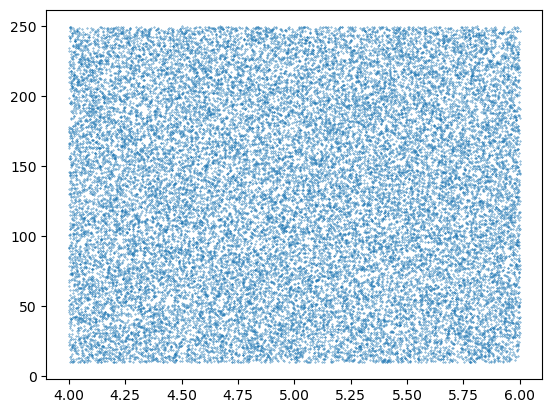

In [68]:
plt.scatter(params[:,0], params[:,1], s=0.1)

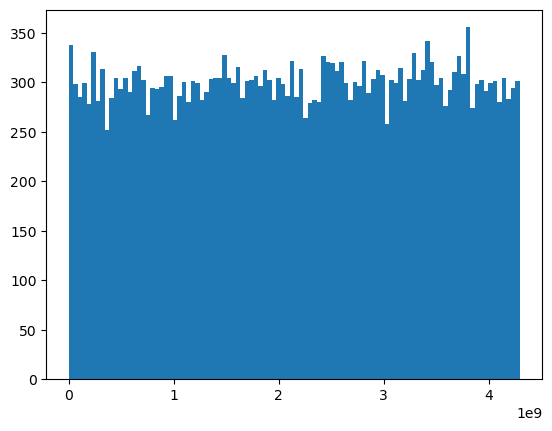

In [71]:
_ = plt.hist(params[:,2],bins=100)

In [73]:
np.unique(params[:,2]).shape

(30000,)

In [75]:
params[:5,2].astype(int)

array([1305177495, 3744271579, 1676976004, 1495391233, 3267974291])

In [80]:
params[:5,:2].astype(np.float64)

array([[  5.34620684, 186.57232434],
       [  5.38555204, 173.7599326 ],
       [  5.33220959, 132.18080689],
       [  4.9907761 , 147.76221102],
       [  5.46876576, 143.69923257]])

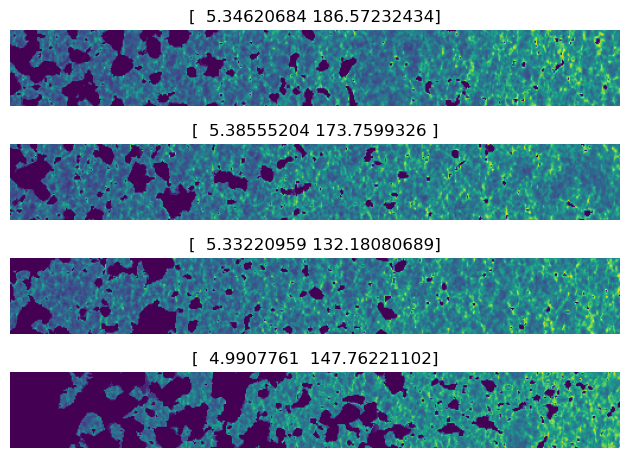

In [67]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4,1)#,figsize=(16,4),dpi=100)
for i, image in enumerate(dataset):
    axs[i].imshow(image[0])
    axs[i].set_axis_off()
    axs[i].set_title(params[i][:2])
fig.show()
plt.tight_layout()

In [11]:
import numpy as np
image = dataset[:4]['image'][0]
image_array = np.array(image)

In [12]:
type(image_array)

numpy.ndarray

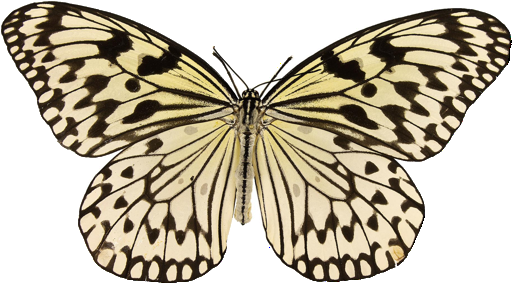

In [13]:
image

In [14]:
image_array.max()

255

In [15]:
image_array.min()

0

In [16]:
from torchvision import transforms
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

/storage/home/hcoda1/3/bxia34/.conda/envs/diffusion/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [17]:
type(dataset[:4]['image'][0])

PIL.PngImagePlugin.PngImageFile

In [18]:
np.min(dataset[:4]['image'][0])

0

In [19]:
np.max(dataset[:4]['image'][0])

255

In [20]:
type(dataset[:4]['image'][0].convert("RGB"))

PIL.Image.Image

In [21]:
np.min(dataset[:4]['image'][0].convert("RGB"))

0

In [22]:
np.max(dataset[:4]['image'][0].convert("RGB"))

255

In [23]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    print(np.shape(images))
    print(np.max(images))
    print(np.min(images))
    return {"images": images}

dataset.set_transform(transform)

In [24]:
images = dataset[:4]['images']
np.shape(images)

(4, 3, 128, 128)
1.0
-0.9843137


(4, 3, 128, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


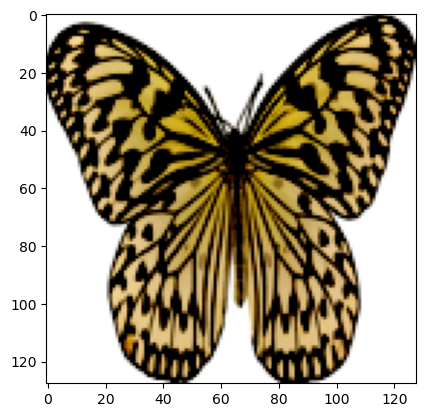

In [25]:
plt.imshow(images[0].permute((1,2,0)))

In [26]:
images[0].min()

tensor(-0.9529)

In [27]:
images[0].max()

tensor(1.)

In [29]:
!module list | grep cuda

No modules loaded
>

In [28]:
!conda list | grep torch

pytorch                   1.12.1          cpu_py39h5d22d69_0    conda-forge
torchvision               0.14.1          cpu_py39hcda3413_0    conda-forge


In [ ]:
import torch

In [30]:
print(torch.__version__)
print(torch.__path__)
print(torch.cuda.is_available())

1.12.1
['/storage/home/hcoda1/3/bxia34/.conda/envs/diffusion/lib/python3.9/site-packages/torch']
False


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name(0)

'Quadro RTX 6000'

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_ds_normalized = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
        )
train_ds_unnormalized = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))

In [6]:
batch_size = 200
# train_loader = torch.utils.data.DataLoader(
#     train_ds_normalized, batch_size=batch_size, shuffle=True,
# )
train_loader = torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=batch_size)

shape_nor = torch.Size([6000, 1, 28, 28])
shape_unn = torch.Size([6000, 1, 28, 28])


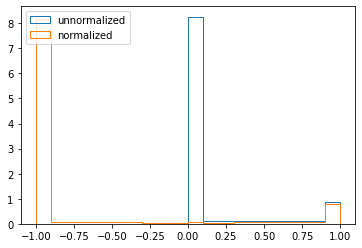

In [7]:
images_normalized, _ = next(iter(torch.utils.data.DataLoader(train_ds_normalized, shuffle=True, batch_size=6000)))
images_unnormal, _ = next(iter(torch.utils.data.DataLoader(train_ds_unnormalized, shuffle=True, batch_size=6000)))
print("shape_nor =", images_normalized.shape)
print("shape_unn =", images_unnormal.shape)
plt.hist(images_unnormal.numpy().reshape(-1), label="unnormalized", density=True, bins=10, histtype="step")
plt.hist(images_normalized.numpy().reshape(-1), label="normalized", density=True, bins=20, histtype="step")
plt.legend()
plt.show()
# plt.imshow(np.transpose(images[0], axes=(1,2,0)), cmap="gray")

In [42]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

model = Unet(
    dim = 64,
    dim_mults = (1,2,4),
    channels = 1
).to(device)

diffusion = GaussianDiffusion(
    model,
    objective = "pred_noise",
    image_size = 28,
    timesteps = 500,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

def plt_sampled_images(savefig="diffusion_epoch.png"):
    sampled_images = diffusion.sample(64).cpu()
    sampled_images = sampled_images.reshape(8,8,1,28,28)
    fig, ax = plt.subplots(8,8, figsize=(8,8), dpi=200, constrained_layout=True)
    fig.suptitle(f"epoch {epoch:03d}/{num_epochs:03d}; step {step:03d}")
    for i in range(8):
        for j in range(8):
            # ax = plt.subplot(4,4,i+1)
            ax[i][j].imshow(np.transpose(sampled_images[i][j], axes=(1,2,0)), 
    cmap = 'gray')
            ax[i][j].axis('off')
            # ax[i][j].set_xticks([])
            # ax[i][j].set_yticks([])
    # plt.tight_layout()
    if savefig != False:
        plt.savefig(savefig)
        plt.close()

In [43]:
num_epochs = 20
for epoch in range(num_epochs):
    start_time = time.time()
    for step, (mnist_images, mnist_labels) in enumerate(train_loader):
        mnist_images = mnist_images.to(device=device)
        optimizer.zero_grad()
        loss = diffusion(mnist_images).to(device)
        loss.backward()
        optimizer.step()
        # if epoch == 0 and step % 5 == 0:
        #     plt_sampled_images(f"diffusion_step{step:03d}.png")
    end_time = time.time()
    print(f"Epoch: {epoch}, {batch_size} batches, {step+1} steps, cost {end_time-start_time:.3f} sec, Loss.: {loss}")
    
    plt_sampled_images(f"diffusion_epoch{epoch:03d}.png")

torch.save(model.state_dict(), "diffusion.pt")


KeyboardInterrupt: 